### This notebook aims to visualize the decision boundary of the OoD detectors.
We use PCA and T-SNE dimension reduction techniques to visualize the logit embeddings in 2D. The distribution of OoD scores in the input space is approximated with contour maps, and the decision boundary is demonstrated with black dashed contour lines. 

We inspect the decision boundary of 12 OoD detectors on the CIFAR10 benchmark connected to 2 model architectures, i.e. WRN-40-2 and ResNet50, and with 4 variants (NT, DA, AT, PAT) respectively. The contour maps are saved in the `results/eval/detector_decision_boundary/` folder.


In [1]:
import numpy as np
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch
from torch.utils.data import DataLoader

os.chdir(os.path.dirname(os.getcwd()))
print("Current working directory: ", os.getcwd())
from models.model_utils import InputNormalizer, load_model
from utils.dataloader import load_dataset
from utils.eval import *
from utils.visualize import *

# Load configs: benchmarks, model variants, OoD datasets and save directory.
with open('config.yaml', 'r') as f:
    configs = yaml.safe_load(f)
    
score_functions = configs["score_functions"]
perturb_functions = configs["perturb_functions"]
rand_seed = configs["rand_seed"]
batch_size = configs["batch_size"]

# Define the order of perturbation functions and model variants in visualizations.
perturb_function_sorter = configs["perturb_functions"]
variant_sorter = ["NT", "DA", "AT", "PAT"]

sns.set_style("whitegrid")

if configs["device"] == "cuda" and torch.cuda.is_available():
    device = torch.device(configs["device"])
else:
    device = torch.device("cpu")
print("Device:", device)


Current working directory:  /home/dingw/work/ood_robustness_eva
Device: cpu


In [ ]:
# Decision boundary visualizaion settings
n_ood = 1000
benchmark = "CIFAR10"
ood_dataset = "SVHN"
img_size = configs["benchmark"][benchmark]["img_size"]
n_classes = configs["benchmark"][benchmark]["num_classes"]
label_class_dict = {0: 'ID - airplanes', 1: 'ID - cars', 2: 'ID - birds', 3: 'ID - cats', 
                    4: 'ID - deer', 5: 'ID - dogs', 6: 'ID - frogs', 7: 'ID - horses', 
                    8: 'ID - ships', 9: 'ID - trucks', -1: f'OoD - {ood_dataset}'}

pca = PCA(n_components=2, random_state=rand_seed)
tsne = TSNE(n_components=2, random_state=rand_seed)

mean: tensor([0.4914, 0.4822, 0.4465]) 
std: tensor([0.2470, 0.2435, 0.2616])
Files already downloaded and verified
Using downloaded and verified file: dataset/SVHN/test_32x32.mat


/home/dingw/work/ood_robustness_eva/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


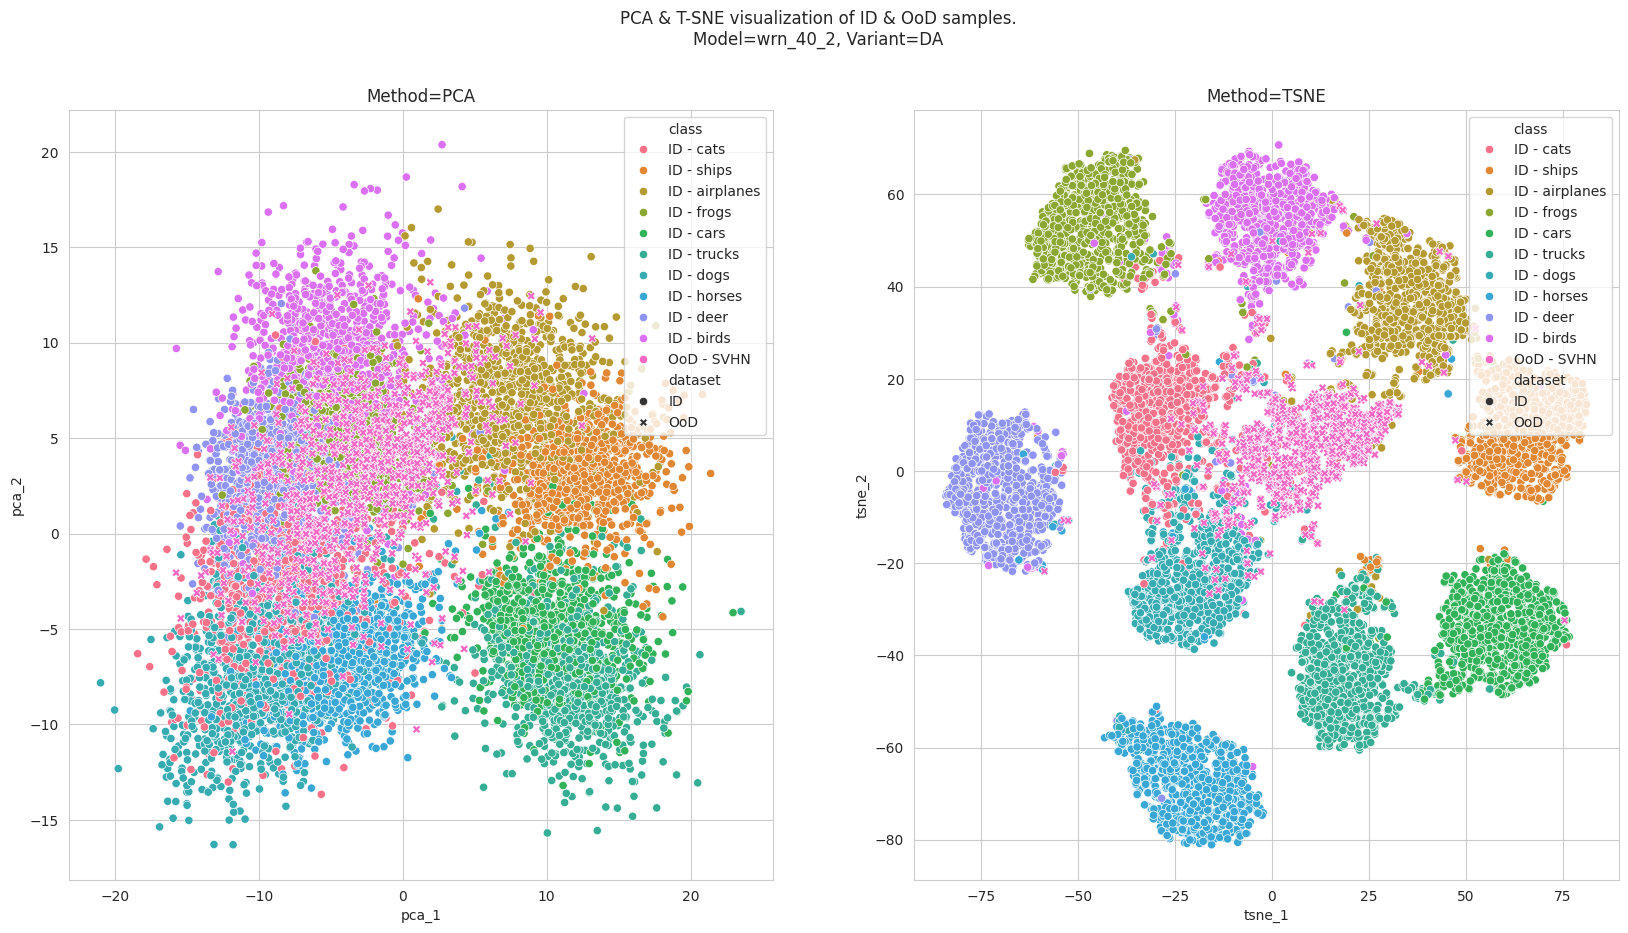

In [ ]:
# Visualize the decision boundary of OoD detectors on the 2D representations of ID & OoD logit embeddings.
for model_name in configs["benchmark"][benchmark]["model"]:
    for variant, weight_name in configs["benchmark"][benchmark]["model"][model_name].items():

        # Load model
        weight_path = f"./models/{benchmark.lower()}/state_dicts/{weight_name}"
        model = load_model(model_name, weight_path, benchmark, device=device)
        model.eval()
        input_normalizer = InputNormalizer(benchmark=benchmark, model_arch=model_name, 
                                        model_weight=weight_name)
        print("mean:", input_normalizer.mean.view(-1), "\nstd:", input_normalizer.std.view(-1))

        # Load dataset
        id_test_data_set, id_test_data_loader = load_dataset("dataset/", benchmark, img_size=img_size, benchmark=benchmark, 
                                                             shuffle=False,
                                                split="test", batch_size=batch_size, normalize=True,
                                                mean=input_normalizer.mean.view(-1), std=input_normalizer.std.view(-1))

        ood_test_data_set, ood_test_data_loader = load_dataset("dataset/", ood_dataset, img_size=img_size, benchmark=benchmark, 
                                                               shuffle=False,
                                                split="test", batch_size=batch_size, normalize=True,
                                                mean=input_normalizer.mean.view(-1), std=input_normalizer.std.view(-1))        


        # Load OoD scores on ID & OoD test dataset from raw experiment result files.
        df_id_scores = pd.DataFrame()
        df_ood_scores = pd.DataFrame()
        id_rlt_path = os.path.join("results", benchmark.lower(), str(rand_seed), model_name, variant, 
                                benchmark, "scores", "temp_all_scores.csv")

        ood_rlt_path = os.path.join("results", benchmark.lower(), str(rand_seed), model_name, variant, 
                                ood_dataset, "scores", "temp_scores.csv")
        if (not os.path.exists(id_rlt_path)) or (not os.path.exists(ood_rlt_path)):
            print(f"File not found: {id_rlt_path} or {ood_rlt_path}.")
            continue

        df_id_scores = pd.read_csv(id_rlt_path).copy()
        df_ood_scores = pd.read_csv(ood_rlt_path).copy()

        # Test the DNN model & OoD detectors on ID & OoD dataset and record the logit embeddings.
        id_logits = torch.empty(0, n_classes)
        with torch.no_grad():
            for x, y in id_test_data_loader:
                x, y = x.to(device), y.to(device)
                logits = model(x)
                id_logits = torch.cat((id_logits, logits.cpu()), dim=0)

        idx = df_ood_scores["idx"].values
        ood_test_data_set = [ood_test_data_set[i] for i in idx]
        ood_test_data_loader = DataLoader(ood_test_data_set, batch_size=batch_size, shuffle=False)

        ood_logits = torch.empty(0, n_classes)
        with torch.no_grad():
            for x, y in ood_test_data_loader:
                x, y = x.to(device), y.to(device)
                logits = model(x)
                ood_logits = torch.cat((ood_logits, logits.cpu()), dim=0)

        # Dimension reduction on the ID & OoD logit embeddings using PCA and T-SNE methods.
        all_logits = torch.cat((id_logits, ood_logits), dim=0)
        logits_pca = pca.fit_transform(all_logits.numpy())
        logits_tsne = tsne.fit_transform(all_logits.numpy())

        # Assembly OoD scores and 2D embedding representations for visualization.
        df_logits_pca = pd.DataFrame(logits_pca, columns=["pca_1", "pca_2"])
        df_logits_tsne = pd.DataFrame(logits_tsne, columns=["tsne_1", "tsne_2"])
        df_id_scores["dataset"] = "ID"
        df_ood_scores["dataset"] = "OoD"
        df_all = pd.concat([df_id_scores, df_ood_scores], axis=0).reset_index(drop=True).copy()
        df_all = pd.concat([df_all, df_logits_pca, df_logits_tsne], axis=1).copy()
        df_all["class"] = df_all["y_true"].apply(lambda x: label_class_dict[x])

        # Inspect the visualization clarity of PCA and T-SNE dimension reduction methods.
        fig, axes = plt.subplots(ncols=2, figsize=(20, 10))
        axes = axes.flatten()
        for ax, method in zip(axes, ["pca", "tsne"]):
            sns.scatterplot(data=df_all, x=f"{method}_1", y=f"{method}_2", hue="class", style="dataset", ax=ax)
            ax.set_title(f"Method={method.upper()}")
            ax.legend(loc="upper right")
        plt.suptitle(f"PCA & T-SNE visualization of ID & OoD samples.\nModel={model_name}, Variant={variant}")
        plt.show() # The visualization of PCA is not clear enough to distinguish ID and OoD samples.
        plt.close("all")

        # Visualize the OoD scores distribution and the decision boundary of 12 OoD detectors on the 
        # 2D embeddings using contour maps.
        save_dir = os.path.join("results", "eval", "detector_decision_boundary", f"{benchmark.lower()}_{model_name}_{variant}")
        for score_func in score_functions:
            if f"{score_func}_score" not in df_id_scores.columns or f"{score_func}_score" not in df_ood_scores.columns:
                continue

            id_scores = df_id_scores[f"{score_func}_score"].to_numpy()
            ood_scores = df_ood_scores[f"{score_func}_score"].to_numpy()
            auroc, aupr_in, aupr_out, fpr, threshold, fpr_out, threshold_out = get_ood_measures(id_scores, ood_scores)

            interpol_contour(df_all["tsne_1"], df_all["tsne_2"], df_all[f"{score_func}_score"], 
                            title=f"OoD detector's decision boundary\nDetector={score_func}, threshold={round(-threshold, 3)}", 
                            s=3,
                            true_labels=df_all["y_true"], marker_mask=df_all["dataset"], marker_panel={"ID": "o", "OoD": "x"},
                            thresholds=[-threshold], label_class_dict=label_class_dict, 
                            save_path=os.path.join(save_dir, f"detector_decision_boundary_{score_func}.png"))
